In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve

In [3]:
data = pd.read_csv('diabetic_data_training.csv',low_memory=False)

In [4]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
1,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30


In [5]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [6]:
data.shape

(91589, 50)

In [7]:
duplicates = data[data.duplicated(subset='patient_nbr', keep=False)]
num_duplicates = duplicates.shape[0]
print('Total number of duplicate patients rows:',num_duplicates)

Total number of duplicate patients rows: 40379


In [8]:
# Note: Duplicate instances  

# https://yungchou.github.io/site/ 
    

In [9]:

data_sorted = data.sort_values(by='time_in_hospital', ascending=False)
data = data_sorted.drop_duplicates(subset='patient_nbr', keep='first')
data.reset_index(drop=True, inplace=True) 
# Kept only the first encounter for each 'patient_nbr' with max time_in_hospital

In [10]:
data.shape

(65932, 50)

In [11]:
# Note: Check out features that do not relate to diabetes

In [12]:
features_to_drop = ['payer_code', 'medical_specialty', 'patient_nbr','weight','examide','citoglipton','glimepiride-pioglitazone']
data = data.drop(columns=features_to_drop, axis=1)

In [13]:
print(data['diag_1'].head(),data['diag_2'].head(),data['diag_3'].head())

0      161
1      440
2    250.8
3      486
4      997
Name: diag_1, dtype: object 0    496
1    682
2    518
3    707
4    599
Name: diag_2, dtype: object 0      512
1      707
2      707
3    250.8
4      576
Name: diag_3, dtype: object


In [14]:
columns_to_replace = ['diag_1', 'diag_2', 'diag_3']

for column in columns_to_replace:
    data[column] = data[column].replace('?', 0)
#Replace ? with 0 

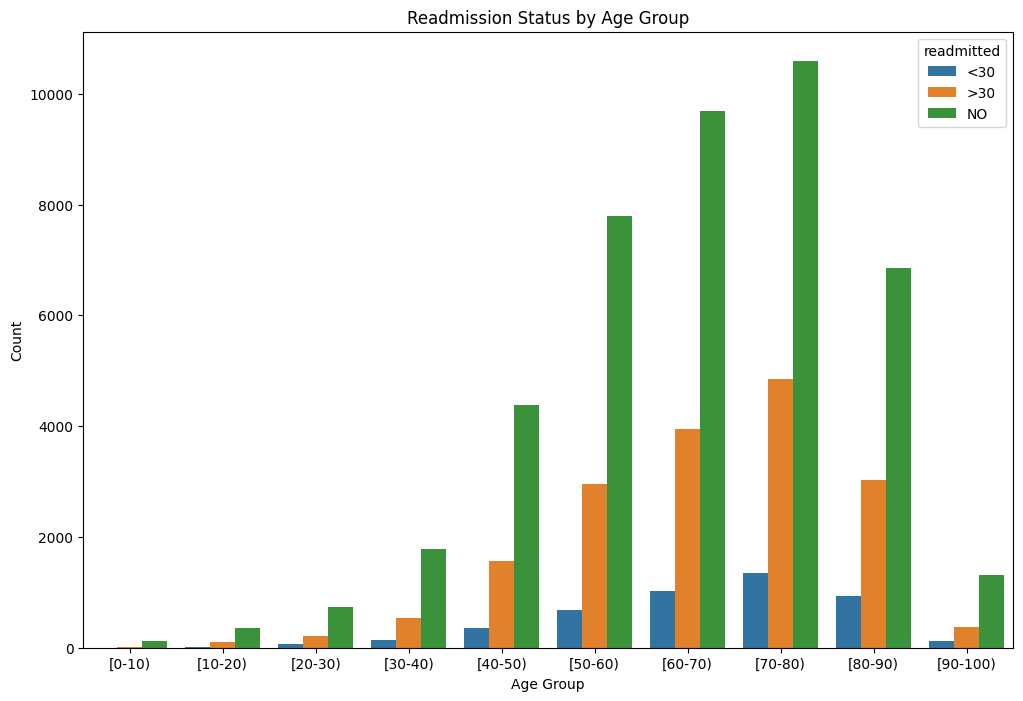

In [15]:


#Readmission vs Age
plt.figure(figsize=(12, 8))
age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
sns.countplot(x='age', hue='readmitted', data=data, order=age_order)
plt.title('Readmission Status by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

In [16]:
#VISUALIZING VARIOUS FEATURES

/var/folders/8_/qxz3mlm91vb1170qn_1d62p40000gn/T/ipykernel_4978/478604370.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='gender', data=data, palette='pastel')


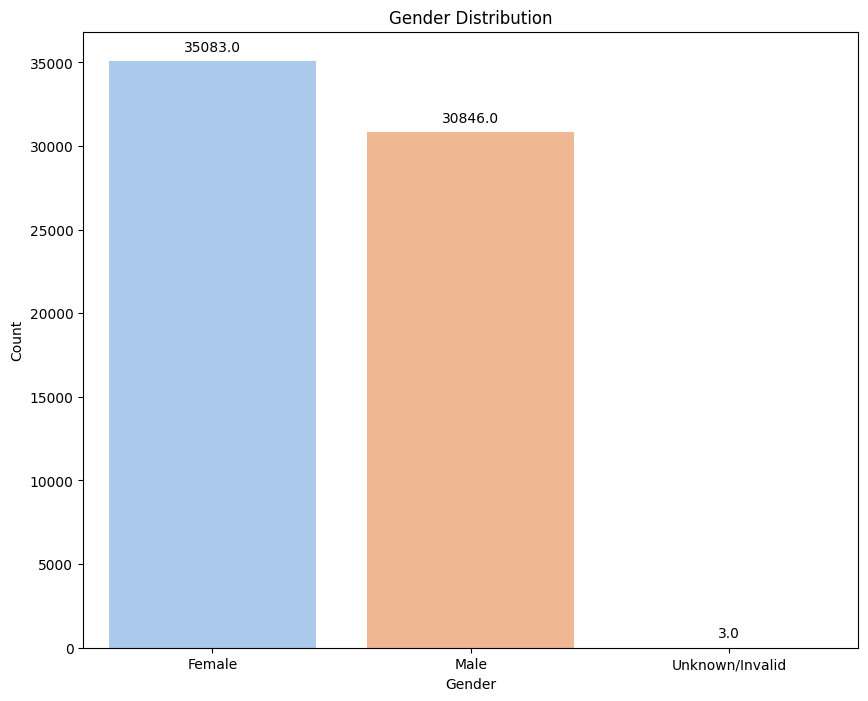

In [17]:
#Gender


plt.figure(figsize=(10, 8))
ax = sns.countplot(x='gender', data=data, palette='pastel')


for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


In [18]:
# Impute Race with clustering

/var/folders/8_/qxz3mlm91vb1170qn_1d62p40000gn/T/ipykernel_4978/2343171416.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='race', data=data, palette='pastel')


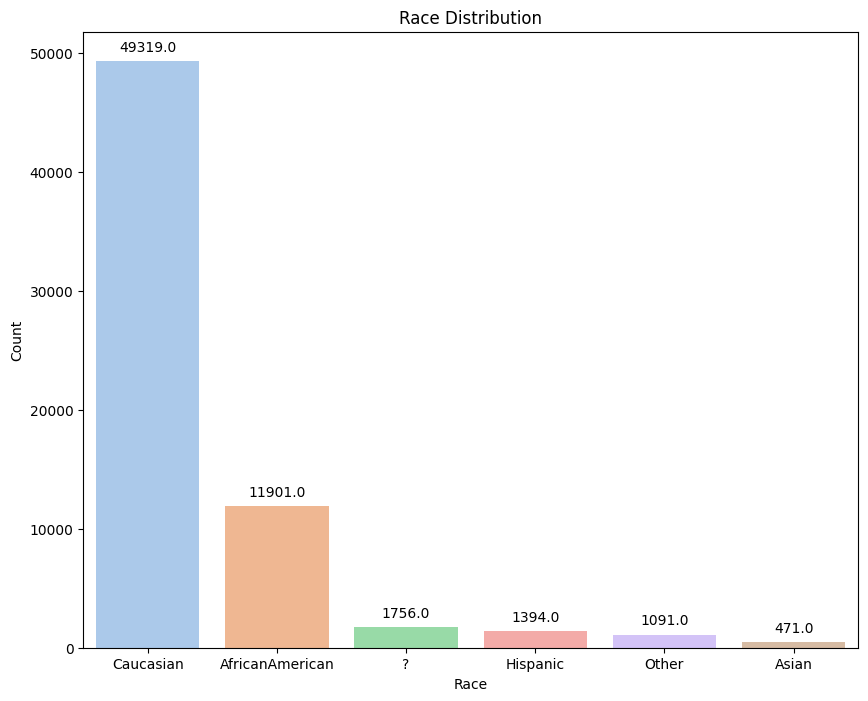

In [19]:
#Race

plt.figure(figsize=(10, 8))
ax = sns.countplot(x='race', data=data, palette='pastel')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Race Distribution')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

In [20]:

data['diag_1'] = pd.to_numeric(data['diag_1'],errors='coerce')

In [21]:

# Label Mapping 
group_mapping = {
    'Circulatory': list(range(390, 460)) + [785],
    'Respiratory': list(range(460, 520)) + [786],
    'Digestive': list(range(520, 580)) + [787],
    'Diabetes': [250 + i / 100.0 for i in range(1, 100)],  # Include decimals from 250.00 to 250.99
    'Injury': list(range(800, 1000)),
    'Musculoskeletal': list(range(710, 740)),
    'Genitourinary': list(range(580, 630)) + [788],
    'Neoplasms': list(range(140, 240)) + [780, 781, 784] + list(range(790, 800)) + list(range(240, 280)) + list(range(680, 710)) + [782] + list(range(1, 140)) + list(range(290, 320))
}

data['diag_1_group'] = data['diag_1'].apply(lambda x: next((k for k, v in group_mapping.items() if x in v), 'Unknown'))

# Assign numerical values to each category
category_numerical_mapping = {
    'Circulatory': 1,
    'Respiratory': 2,
    'Digestive': 3,
    'Diabetes': 4,
    'Injury': 5,
    'Musculoskeletal': 6,
    'Genitourinary': 7,
    'Neoplasms': 8,
}

data['diag_1_numerical'] = data['diag_1_group'].map(category_numerical_mapping)
data['diag_1_numerical'].fillna(9, inplace=True)

print(data[['diag_1', 'diag_1_group', 'diag_1_numerical']].head(40))

    diag_1 diag_1_group  diag_1_numerical
0   161.00    Neoplasms               8.0
1   440.00  Circulatory               1.0
2   250.80     Diabetes               4.0
3   486.00  Respiratory               2.0
4   997.00       Injury               5.0
5   250.82     Diabetes               4.0
6   434.00  Circulatory               1.0
7   294.00    Neoplasms               8.0
8   250.70     Diabetes               4.0
9   996.00       Injury               5.0
10  410.00  Circulatory               1.0
11     NaN      Unknown               9.0
12  296.00    Neoplasms               8.0
13  414.00  Circulatory               1.0
14  578.00    Digestive               3.0
15  997.00       Injury               5.0
16  296.00    Neoplasms               8.0
17  577.00    Digestive               3.0
18  427.00  Circulatory               1.0
19  486.00  Respiratory               2.0
20   38.00    Neoplasms               8.0
21  574.00    Digestive               3.0
22  414.00  Circulatory           

In [22]:
data['diag_2'] = pd.to_numeric(data['diag_2'],errors='coerce')
data['diag_3'] = pd.to_numeric(data['diag_3'],errors='coerce') 

data['diag_2_group'] = data['diag_2'].apply(lambda x: next((k for k, v in group_mapping.items() if x in v), 'Unknown'))
data['diag_2_numerical'] = data['diag_2_group'].map(category_numerical_mapping)
data['diag_2_numerical'].fillna(9, inplace=True)

# Apply the same code for 'diag_3'
data['diag_3_group'] = data['diag_3'].apply(lambda x: next((k for k, v in group_mapping.items() if x in v), 'Unknown'))
data['diag_3_numerical'] = data['diag_3_group'].map(category_numerical_mapping)
data['diag_3_numerical'].fillna(9, inplace=True)

print(data[['diag_1', 'diag_1_group', 'diag_1_numerical', 'diag_2', 'diag_2_group', 'diag_2_numerical', 'diag_3', 'diag_3_group', 'diag_3_numerical']].head(40))

    diag_1 diag_1_group  diag_1_numerical  diag_2     diag_2_group  \
0   161.00    Neoplasms               8.0  496.00      Respiratory   
1   440.00  Circulatory               1.0  682.00        Neoplasms   
2   250.80     Diabetes               4.0  518.00      Respiratory   
3   486.00  Respiratory               2.0  707.00        Neoplasms   
4   997.00       Injury               5.0  599.00    Genitourinary   
5   250.82     Diabetes               4.0  788.00    Genitourinary   
6   434.00  Circulatory               1.0  780.00        Neoplasms   
7   294.00    Neoplasms               8.0  250.81         Diabetes   
8   250.70     Diabetes               4.0   40.00        Neoplasms   
9   996.00       Injury               5.0  511.00      Respiratory   
10  410.00  Circulatory               1.0  428.00      Circulatory   
11     NaN      Unknown               9.0  719.00  Musculoskeletal   
12  296.00    Neoplasms               8.0  496.00      Respiratory   
13  414.00  Circulat

In [23]:
features_to_drop = ['diag_1', 'diag_2', 'diag_3','diag_1_group','diag_2_group','diag_3_group']
data = data.drop(columns=features_to_drop, axis=1)

In [24]:
data.columns

Index(['encounter_id', 'race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted', 'diag_1_numerical', 'diag_2_numerical',
       'diag_3_numerical'],
      dtype='object')

In [25]:
label_encoder = LabelEncoder()
features_to_encode = ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted']

for column in features_to_encode:
    data[column] = label_encoder.fit_transform(data[column])

<Axes: >

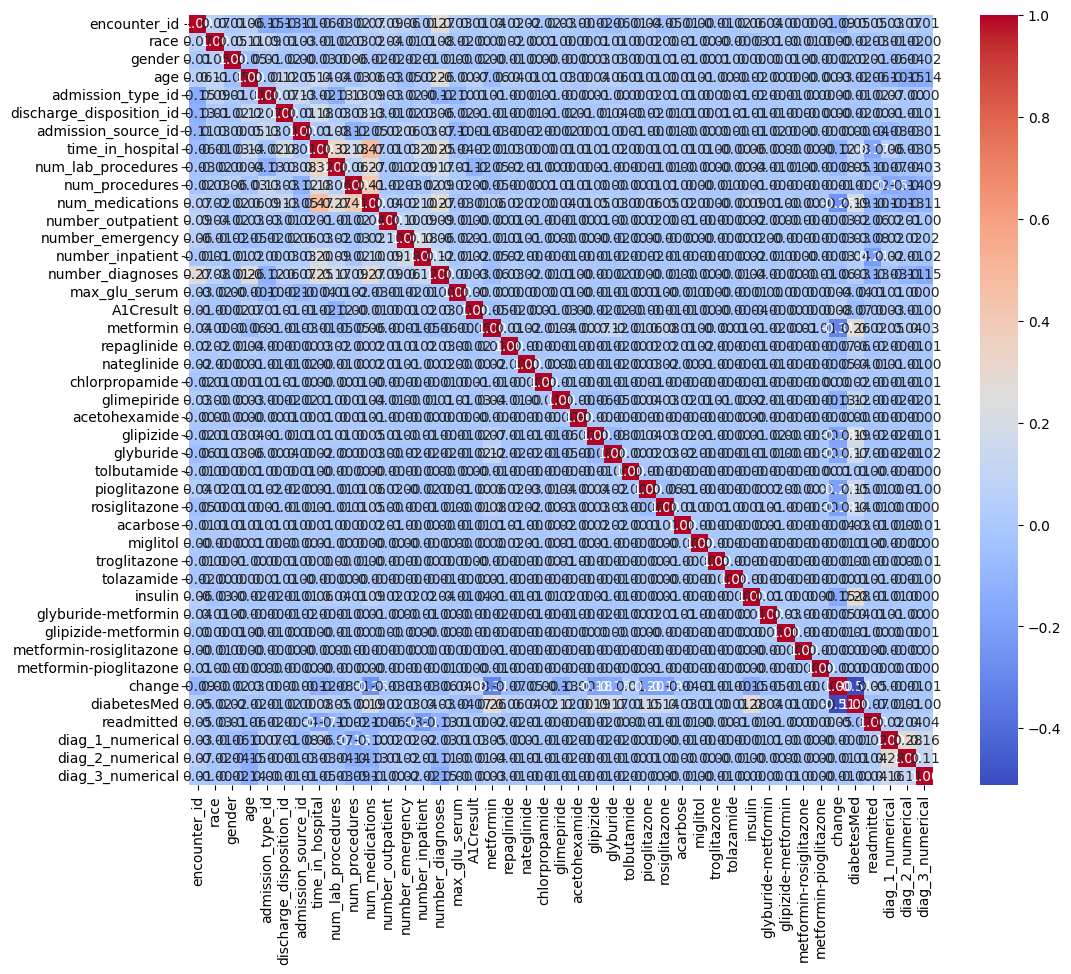

In [26]:
correlation_matrix = data.corr() 
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

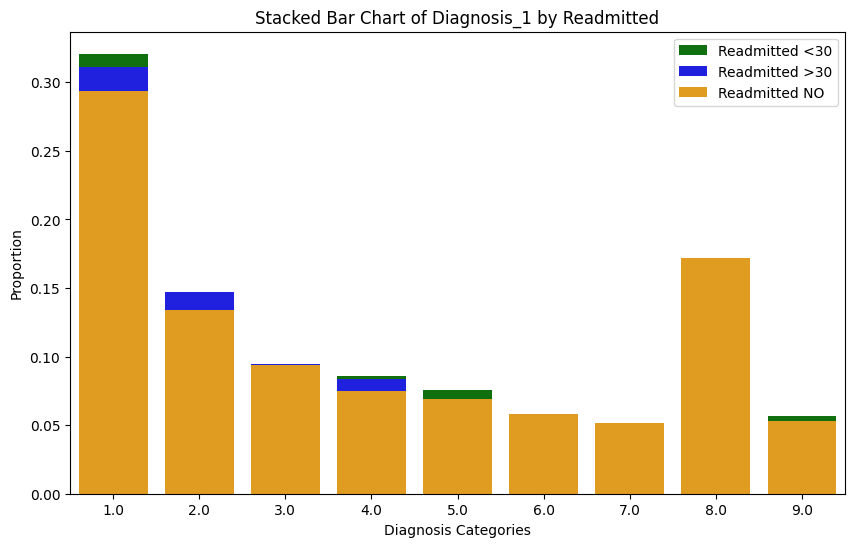

In [27]:
# Group data
grouped_data = data.groupby(['readmitted', 'diag_1_numerical']).size().unstack()

# Normalize the data to get proportions
grouped_data = grouped_data.div(grouped_data.sum(axis=1), axis=0)

# Plot stacked bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=grouped_data.columns, y=grouped_data.loc[0], label='Readmitted <30', color='green')
sns.barplot(x=grouped_data.columns, y=grouped_data.loc[1], label='Readmitted >30', color='blue')
sns.barplot(x=grouped_data.columns, y=grouped_data.loc[2], label='Readmitted NO', color='orange')

plt.title('Stacked Bar Chart of Diagnosis_1 by Readmitted')
plt.xlabel('Diagnosis Categories')
plt.ylabel('Proportion')
plt.legend()
plt.show()

In [28]:
data['readmitted'].value_counts()

2    43611
1    17637
0     4684
Name: readmitted, dtype: int64

In [29]:
column_types = data.dtypes

for column, dtype in column_types.items():
    print(f'Column: {column}, Type: {dtype}')

Column: encounter_id, Type: int64
Column: race, Type: int64
Column: gender, Type: int64
Column: age, Type: int64
Column: admission_type_id, Type: int64
Column: discharge_disposition_id, Type: int64
Column: admission_source_id, Type: int64
Column: time_in_hospital, Type: int64
Column: num_lab_procedures, Type: int64
Column: num_procedures, Type: int64
Column: num_medications, Type: int64
Column: number_outpatient, Type: int64
Column: number_emergency, Type: int64
Column: number_inpatient, Type: int64
Column: number_diagnoses, Type: int64
Column: max_glu_serum, Type: int64
Column: A1Cresult, Type: int64
Column: metformin, Type: int64
Column: repaglinide, Type: int64
Column: nateglinide, Type: int64
Column: chlorpropamide, Type: int64
Column: glimepiride, Type: int64
Column: acetohexamide, Type: int64
Column: glipizide, Type: int64
Column: glyburide, Type: int64
Column: tolbutamide, Type: int64
Column: pioglitazone, Type: int64
Column: rosiglitazone, Type: int64
Column: acarbose, Type: in

In [30]:
data.head()

,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_numerical,diag_2_numerical,diag_3_numerical
0,70905930,3,0,8,1,6,7,14,53,3,...,1,0,0,0,1,1,0,8.0,2.0,2.0
1,56000466,1,0,7,1,18,7,14,50,3,...,1,0,0,0,1,1,0,1.0,8.0,8.0
2,432673982,3,0,6,3,3,1,14,64,1,...,1,0,0,0,0,1,1,4.0,2.0,8.0
3,278906352,3,0,9,2,3,7,14,55,6,...,1,0,0,0,0,1,2,2.0,8.0,4.0
4,361994252,3,0,7,1,6,7,14,28,2,...,1,0,0,0,1,0,1,5.0,7.0,3.0


### Cluster data to impute race column

In [31]:
data.loc[data['race'] == 0, 'race'] = pd.NA

X = data.drop(['encounter_id', 'readmitted'], axis=1)

n_clusters = 20  # Adjust as needed

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X['cluster'] = kmeans.fit_predict(X.drop(['race'], axis=1))

imputer = SimpleImputer(strategy='most_frequent')

for cluster in range(n_clusters):
    cluster_indices = X[X['cluster'] == cluster].index
    data.loc[cluster_indices, 'race'] = imputer.fit_transform(data.loc[cluster_indices, ['race']])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [32]:
data['race'].value_counts()

3.0    51075
1.0    11901
4.0     1394
5.0     1091
2.0      471
Name: race, dtype: int64

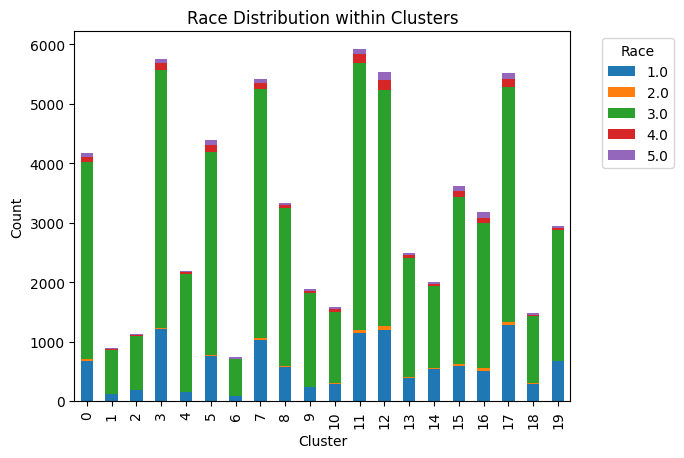

In [33]:
race_distribution = X.groupby(['cluster', 'race']).size().unstack().fillna(0)

race_distribution.plot(kind='bar', stacked=True)
plt.title('Race Distribution within Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### PCA Feature Selection

In [37]:
X = data.drop('readmitted', axis=1)  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_components = 15  # You can choose the desired number of components

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)


columns = [f'PC{i+1}' for i in range(n_components)]
pc_df = pd.DataFrame(data=X_pca, columns=columns)

result_df = pd.concat([pc_df, data['readmitted']], axis=1)

result_df.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,readmitted
0,1.304854,-1.943119,0.304645,0.953527,0.013927,0.116963,-1.534644,-0.453712,-0.363965,0.098402,0.511511,-0.653501,-0.310133,-0.013434,-0.120156,0
1,2.603551,-1.517813,-0.202449,2.994473,-0.771851,1.067504,-1.406829,-0.810966,-1.777119,0.716236,-1.932495,1.408646,1.531272,2.276250,-0.990205,0
2,5.659261,-1.820787,4.187548,1.153567,0.872433,-2.756624,2.174303,1.185866,0.712726,1.269076,-0.227027,1.583810,0.409631,0.099296,0.868318,1
3,3.124339,-2.178292,1.593107,2.052650,0.245528,-0.488420,1.046964,1.342936,0.372496,-0.254447,-0.184014,0.412326,0.810716,0.085658,0.985550,2
4,0.292932,-2.465371,1.904897,0.456402,-0.141408,-1.081018,-0.998544,-0.266980,0.067801,-0.211636,-0.181315,0.059985,-0.305374,-0.294168,0.164026,1


### Playing around with XGBoost

In [35]:
X = data.drop('readmitted', axis=1)
y = data['readmitted']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6801395313566391


In [36]:
X = result_df.drop('readmitted', axis=1)
y = result_df['readmitted']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6695230150906195
